In [1]:
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

from functions import *
from data_cleaning import DataCleaning

from betfairlightweight import StreamListener, APIClient
import os


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

/Users/andrewbarwise/miniforge3/envs/horse_trading/lib/python3.11/site-packages/pydantic/_internal/_fields.py:151: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/Users/andrewbarwise/miniforge3/envs/horse_trading/lib/python3.11/site-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


In [2]:
df = pd.read_csv('../data/raw_proform/2024_09_28.csv')

df.head()

,Race Time,Course,Distance (y),Race Type,Official Going,Classifications,Position,Horse,Jockey Claim,Weight (pounds),SP Odds Decimal,BF Decimal SP,"Won (1=Won, 0=Lost)",PRC Average,PRC Last Run,PRC 2nd Last Run,PRC 3rd Last Run,Pace Rating,OR,Tissue Odds Decimal,Main,Main Stats,Stats,Trn Stats,Jky Stats,TrnJky Stats,Hrs Stats,HA Career Speed Rating,HA Last 1 Year Speed Rating,MR Career Speed Rating,MR Last 1 Year Speed Rating,MR Last 3 Runs Speed Rating,LTO Speed Rating,2nd LTO Speed Rating,3rd LTO Speed Rating,4th LTOt Speed Rating,Evening Price,Breakfast Price,Morning Price,dyHA,dyLTO,dyAVG,dyAVG(x),dyMR,dyMR(x),dy2HA,Finished Races SR,WON SR Before,Won P/L Before,Plc SR Before,DSLR(F),DSLR(J),FLAT TURF Runs Before,FLAT AW Runs Before,CHASE Runs Before,HURDLE Runs Before,NHF Runs Before,ALL FLAT Runs Before,FLAT TURF Wins Before,FLAT AW Wins Before,CHASE Wins Before,HURDLE Wins Before,NHF Wins Before,Distance In Yards LTO,Official Rating LTO,Distance To Winner LTO,Betfair SP Odds LTO (Decimcal),Speed Rating LTO,PRC Average LTO,PRC Last Run LTO,PRC 2nd Last Run LTO,PRC 3rd Last Run LTO,Cherry Picked Rating,Today's Going Wins,Today's Going Places,Today's Going Runs,Today's Distance Wins,Today's Distance Places,Today's Distance Runs,Today's Class Wins,Today's Class Places,Today's Class Runs,Today's Course Wins,Today's Course Places,Today's Course Runs,Heavy/Soft Ground Wins,Heavy/Soft Ground Places,Heavy/Soft Ground Runs,Good to Soft Ground Wins,Good to Soft Ground Runs,Good Ground Wins,Good Ground Runs,Good to Firm Ground Wins,Good to Firm Ground Runs
0,31/08/2021 1:00:00 PM,Ripon,1100,Turf,Good,Nov-Fil,1,Selby's Pride,0,124,2.25,2.42,1,61,85,64,34,4,75,4.33,340,578,238,76,75,71,16,50,50,48,48,48,50,48,44,0,1.73,1.83,2.00,50.0,50.0,47.0,47.0,48.0,48.0,48.0,NaN,0.00,-3.0,33.33,19.0,NaN,3,0,0,0,0,3,0,0,0,0,0,1100,0.0,0.30,46.00,50.0,49.0,64.0,34.0,0.0,NaN,0,1,1,0,1,3,0,1,3,0,0,0,0,0,1,0,0,0,1,0,1
1,31/08/2021 1:00:00 PM,Ripon,1100,Turf,Good,Nov-Fil,2,Lucy Lulu,3,130,2.75,2.89,0,75,78,74,72,8,76,3.25,374,748,374,90,92,92,100,68,68,57,57,63,68,63,55,55,3.25,2.75,2.88,68.0,68.0,58.0,62.0,57.0,63.0,63.0,NaN,16.67,9.0,16.67,10.0,NaN,6,0,0,0,0,6,1,0,0,0,0,1337,75.0,3.80,11.39,68.0,77.0,74.0,72.0,84.0,NaN,0,0,0,1,1,5,1,1,2,0,0,0,0,1,3,0,1,0,0,1,2
2,31/08/2021 1:00:00 PM,Ripon,1100,Turf,Good,Nov-Fil,3,Prayer Matt,0,124,15.00,20.34,0,44,44,0,0,0,0,9.00,298,628,330,86,87,77,80,40,40,40,40,40,40,0,0,0,26.00,29.00,29.00,40.0,40.0,40.0,40.0,40.0,40.0,NaN,NaN,0.00,-1.0,0.00,106.0,NaN,1,0,0,0,0,1,0,0,0,0,0,1317,0.0,7.20,37.81,40.0,0.0,0.0,0.0,0.0,NaN,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,31/08/2021 1:00:00 PM,Ripon,1100,Turf,Good,Nov-Fil,4,Ardom's Lady,0,124,26.00,29.00,0,27,27,0,0,0,0,9.00,293,609,316,90,81,87,58,39,39,39,39,39,39,0,0,0,34.00,29.00,26.00,39.0,39.0,39.0,39.0,39.0,39.0,NaN,NaN,0.00,-1.0,0.00,22.0,NaN,1,0,0,0,0,1,0,0,0,0,0,1100,0.0,13.55,49.73,39.0,0.0,0.0,0.0,0.0,NaN,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0
4,31/08/2021 1:00:00 PM,Ripon,1100,Turf,Good,Nov-Fil,5,Lady Ardad,0,124,6.50,9.00,0,40,40,0,0,2,0,5.50,329,661,332,85,88,87,72,48,48,48,48,48,48,0,0,0,8.00,7.50,6.50,48.0,48.0,48.0,48.0,48.0,48.0,NaN,NaN,0.00,-1.0,0.00,16.0,NaN,1,0,0,0,0,1,0,0,0,0,0,1103,0.0,4.20,12.00,48.0,0.0,0.0,0.0,0.0,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [3]:
bins = [800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600,
        2800, 3000, 3200, 3400, 3600, 3800, 4000]

df['distance_bucket'] = pd.cut(df['Distance (y)'], bins = bins,
                               labels=['800-1000', '1000-1200', '1200-1400', '1400-1600', '1600-1800', '1800-2000',
                                       '2000-2200', '2200-2400', '2400-2600', '2600-2800', '2800-3000',
                                       '3000-3200', '3200-3400', '3400-3600', '3600-3800', '3800-4000'])

In [4]:
df['evening_morning_price'] = (df['Morning Price'] / df['Evening Price'])

df['breakfast_morning_price'] = (df['Morning Price'] / df['Breakfast Price'])

In [5]:
df['weight'] = df['Weight (pounds)'] - df['Jockey Claim']

df['SP Odds Decimal1'] = df['BF Decimal SP']

In [6]:
list = df.columns.tolist()

In [7]:
remove = ['Race Time', 'Course', 'Distance (y)', 'Race Type', 'Official Going',
       'Classifications', 'Position', 'Horse', 'Jockey Claim',
       'Weight (pounds)','distance_bucket']

list1 = [x for x in list if x not in remove]

In [8]:
normalized_df = DataCleaning.normalize_columns(df, list1)

X = normalized_df.drop(['Race Time', 'Course', 'Horse', 'Distance (y)', 'Race Type', 'Official Going', \
                        'Classifications', 'Position', 'Horse', 'Jockey Claim', 'Weight (pounds)', 'Won (1=Won, 0=Lost)', 'distance_bucket', 'SP Odds Decimal', \
                            'Evening Price', 'Breakfast Price', 'Morning Price', 'Main Stats'], axis = 1)
y = normalized_df[['Won (1=Won, 0=Lost)']]

X.fillna(0, inplace = True)

/Users/andrewbarwise/miniforge3/envs/horse_trading/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:480: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/andrewbarwise/miniforge3/envs/horse_trading/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:481: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [9]:
%%script false --no-raise-error

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X, y)

# Get feature importances
importances = rf_classifier.feature_importances_
feature_names = X.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:10]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(10), importances[indices], align="center")
plt.xticks(range(10), feature_names[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.show()

## look at thresholds around variance

/Users/andrewbarwise/miniforge3/envs/horse_trading/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


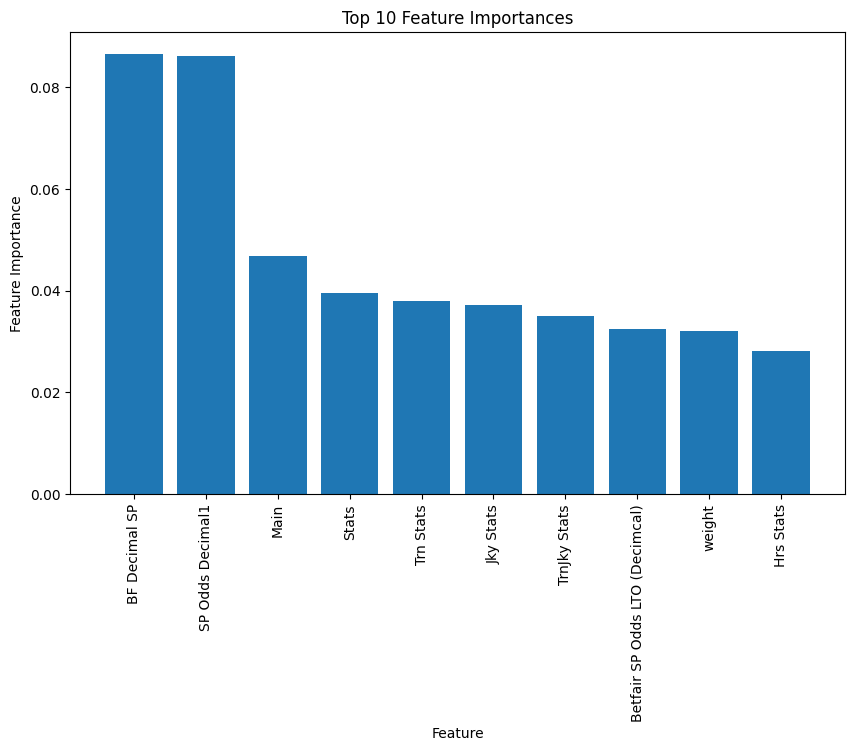

In [10]:
# Remove features with very low variance
threshold = 0.01  # Customize the threshold for your use case
selector = VarianceThreshold(threshold=threshold)
X_reduced = selector.fit_transform(X)

# Get the indices of the features that were kept
support = selector.get_support(indices=True)

# Create a list of feature names for the reduced dataset
reduced_feature_names = X.columns[support]

# Train a RandomForest classifier on the reduced dataset
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_reduced, y)

# Get feature importances
importances = rf_classifier.feature_importances_

# Sort feature importances in descending order and select top 10
indices = np.argsort(importances)[::-1][:10]

# Plot feature importances for the top 10 features
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.bar(range(10), importances[indices], align="center")
plt.xticks(range(10), reduced_feature_names[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.show()


## Recursive Feature Elimination
Use RFE to reduce the feature space by removing the least important features recursively.

In [11]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(rf_classifier, n_features_to_select=10)  # Customize number of features
rfe.fit(X, y)
print("Selected features:", X.columns[rfe.support_])

/Users/andrewbarwise/miniforge3/envs/horse_trading/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


KeyboardInterrupt: 

## remove highly correlated features and then use RFE

In [15]:
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

df_reduced = X.drop(columns=to_drop)


In [19]:
to_drop

['PRC Last Run',
 'HA Last 1 Year Speed Rating',
 'MR Career Speed Rating',
 'MR Last 1 Year Speed Rating',
 'MR Last 3 Runs Speed Rating',
 'LTO Speed Rating',
 'dyHA',
 'dyLTO',
 'dyAVG',
 'dyAVG(x)',
 'dyMR',
 'dyMR(x)',
 'ALL FLAT Runs Before',
 'Speed Rating LTO',
 'PRC Last Run LTO',
 'SP Odds Decimal1']

In [16]:
len(df_reduced.columns)

66

In [18]:
rf_classifier1 = RandomForestClassifier(n_estimators=100, random_state=42)
rfe1 = RFE(rf_classifier1, n_features_to_select=10)  # Customize number of features
rfe1.fit(df_reduced, y)
print("Selected features:", df_reduced.columns[rfe1.support_])

/Users/andrewbarwise/miniforge3/envs/horse_trading/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/andrewbarwise/miniforge3/envs/horse_trading/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/andrewbarwise/miniforge3/envs/horse_trading/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/andrewbarwise/miniforge3/envs/horse_trading/lib/python3.11/site-packages/sklea

Selected features: Index(['BF Decimal SP', 'Main', 'Stats', 'Trn Stats', 'Jky Stats',
       'TrnJky Stats', 'Won P/L Before', 'DSLR(F)',
       'Betfair SP Odds LTO (Decimcal)', 'evening_morning_price'],
      dtype='object')
